In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

In [5]:
#load data

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dir = '/home/liu/mysoft/pycharm/project/QuantistStudio/MyTest/test_pytorch/data/'
data_dir = dir + 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

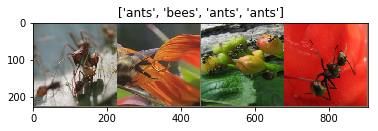

In [7]:
# Visualize a few images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [10]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/liu/.torch/models/resnet18-5c106cde.pth


  0%|          | 0/46827520 [00:00<?, ?it/s]

  0%|          | 16384/46827520 [00:00<12:03, 64740.28it/s]

  0%|          | 32768/46827520 [00:00<11:32, 67577.03it/s]

  0%|          | 49152/46827520 [00:00<10:39, 73189.77it/s]

  0%|          | 90112/46827520 [00:00<08:41, 89573.67it/s]

  0%|          | 155648/46827520 [00:00<06:27, 120491.52it/s]

  0%|          | 204800/46827520 [00:01<05:07, 151650.03it/s]

  1%|          | 335872/46827520 [00:01<03:45, 205818.68it/s]

  1%|          | 401408/46827520 [00:01<02:59, 258101.13it/s]

  1%|▏         | 630784/46827520 [00:01<02:11, 351259.32it/s]

  2%|▏         | 794624/46827520 [00:01<01:40, 457541.20it/s]

  3%|▎         | 1187840/46827520 [00:01<01:13, 622552.36it/s]

  3%|▎         | 1597440/46827520 [00:01<00:54, 826601.76it/s]

  4%|▍         | 2056192/46827520 [00:01<00:40, 1095713.09it/s]

  6%|▌         | 2580480/46827520 [00:01<00:30, 1435872.60it/s]

  7%|▋         | 3121152/46827520 [00:02<00:23, 1837234.42it/s]

  8%|▊         | 3645440/46827520 [00:02<00:18, 2274157.22it/s]

  9%|▉         | 4153344/46827520 [00:02<00:15, 2700297.76it/s]

 10%|▉         | 4677632/46827520 [00:02<00:13, 3154633.40it/s]

 11%|█         | 5185536/46827520 [00:02<00:11, 3549993.16it/s]

 12%|█▏        | 5693440/46827520 [00:02<00:10, 3901858.16it/s]

 13%|█▎        | 6184960/46827520 [00:02<00:09, 4151857.65it/s]

 14%|█▍        | 6742016/46827520 [00:02<00:08, 4479338.79it/s]

 15%|█▌        | 7249920/46827520 [00:02<00:08, 4596948.84it/s]

 17%|█▋        | 7774208/46827520 [00:02<00:08, 4772288.60it/s]

 18%|█▊        | 8290304/46827520 [00:03<00:07, 4855179.20it/s]

 19%|█▉        | 8806400/46827520 [00:03<00:07, 4935440.75it/s]

 20%|█▉        | 9330688/46827520 [00:03<00:07, 5003314.05it/s]

 21%|██        | 9846784/46827520 [00:03<00:07, 4910353.90it/s]

 22%|██▏       | 10362880/46827520 [00:03<00:07, 4968105.23it/s]

 23%|██▎       | 10887168/46827520 [00:03<00:07, 5041433.10it/s]

 24%|██▍       | 11403264/46827520 [00:03<00:06, 5071772.12it/s]

 25%|██▌       | 11919360/46827520 [00:03<00:06, 5096371.72it/s]

 27%|██▋       | 12443648/46827520 [00:03<00:06, 5111008.69it/s]

 28%|██▊       | 12967936/46827520 [00:03<00:06, 5122142.11it/s]

 29%|██▉       | 13492224/46827520 [00:04<00:06, 5118272.66it/s]

 30%|██▉       | 14016512/46827520 [00:04<00:06, 5140024.77it/s]

 31%|███       | 14532608/46827520 [00:04<00:06, 5141529.11it/s]

 32%|███▏      | 15048704/46827520 [00:04<00:06, 5095131.89it/s]

 33%|███▎      | 15564800/46827520 [00:04<00:06, 5082457.22it/s]

 34%|███▍      | 16097280/46827520 [00:04<00:05, 5125178.89it/s]

 35%|███▌      | 16621568/46827520 [00:04<00:05, 5145786.85it/s]

 37%|███▋      | 17145856/46827520 [00:04<00:05, 5170499.62it/s]

 38%|███▊      | 17670144/46827520 [00:05<00:13, 2096759.23it/s]

 41%|████      | 19226624/46827520 [00:05<00:10, 2643588.31it/s]

 43%|████▎     | 19996672/46827520 [00:05<00:08, 3280624.35it/s]

 48%|████▊     | 22274048/46827520 [00:05<00:05, 4407274.58it/s]

 50%|████▉     | 23330816/46827520 [00:06<00:05, 4489160.36it/s]

 52%|█████▏    | 24215552/46827520 [00:06<00:04, 4647240.32it/s]

 53%|█████▎    | 24985600/46827520 [00:06<00:04, 4829100.50it/s]

 55%|█████▍    | 25690112/46827520 [00:06<00:04, 4866579.77it/s]

 56%|█████▌    | 26329088/46827520 [00:06<00:04, 4961810.75it/s]

 58%|█████▊    | 26935296/46827520 [00:06<00:03, 5054854.15it/s]

 59%|█████▉    | 27516928/46827520 [00:06<00:03, 5075771.76it/s]

 60%|█████▉    | 28082176/46827520 [00:06<00:03, 5120804.63it/s]

 61%|██████    | 28631040/46827520 [00:07<00:03, 5154159.80it/s]

 62%|██████▏   | 29179904/46827520 [00:07<00:03, 5182996.46it/s]

 63%|██████▎   | 29720576/46827520 [00:07<00:03, 5107780.03it/s]

 65%|██████▍   | 30244864/46827520 [00:07<00:03, 5098320.31it/s]

 66%|██████▌   | 30769152/46827520 [00:07<00:03, 5109842.92it/s]

 67%|██████▋   | 31293440/46827520 [00:07<00:03, 5136376.82it/s]

 68%|██████▊   | 31825920/46827520 [00:07<00:02, 5158281.39it/s]

 69%|██████▉   | 32366592/46827520 [00:07<00:02, 5216422.49it/s]

 70%|███████   | 32890880/46827520 [00:07<00:02, 5182267.49it/s]

 71%|███████▏  | 33415168/46827520 [00:08<00:02, 5183129.05it/s]

 72%|███████▏  | 33939456/46827520 [00:08<00:02, 5144867.12it/s]

 74%|███████▎  | 34480128/46827520 [00:08<00:02, 5216827.14it/s]

 75%|███████▍  | 35004416/46827520 [00:08<00:02, 4957228.58it/s]

 76%|███████▌  | 35512320/46827520 [00:08<00:02, 4963166.70it/s]

 77%|███████▋  | 36036608/46827520 [00:08<00:02, 5040477.43it/s]

 78%|███████▊  | 36593664/46827520 [00:08<00:01, 5125462.77it/s]

 79%|███████▉  | 37109760/46827520 [00:08<00:01, 5000669.25it/s]

 80%|████████  | 37625856/46827520 [00:08<00:01, 5018186.15it/s]

 81%|████████▏ | 38150144/46827520 [00:08<00:01, 5056666.80it/s]

 83%|████████▎ | 38674432/46827520 [00:09<00:01, 5092659.48it/s]

 84%|████████▎ | 39215104/46827520 [00:09<00:01, 5142806.10it/s]

 85%|████████▍ | 39739392/46827520 [00:09<00:01, 5162295.81it/s]

 86%|████████▌ | 40263680/46827520 [00:09<00:01, 5167754.15it/s]

 87%|████████▋ | 40787968/46827520 [00:09<00:01, 5141008.78it/s]

 88%|████████▊ | 41312256/46827520 [00:09<00:01, 5145615.88it/s]

 89%|████████▉ | 41828352/46827520 [00:09<00:00, 5043126.14it/s]

 90%|█████████ | 42360832/46827520 [00:09<00:00, 5057467.00it/s]

 92%|█████████▏| 42901504/46827520 [00:09<00:00, 5115869.91it/s]

 93%|█████████▎| 43417600/46827520 [00:09<00:00, 5103195.94it/s]

 94%|█████████▍| 43933696/46827520 [00:10<00:00, 5092588.88it/s]

 95%|█████████▍| 44474368/46827520 [00:10<00:00, 5127890.40it/s]

 96%|█████████▌| 44990464/46827520 [00:10<00:00, 5100758.57it/s]

 97%|█████████▋| 45506560/46827520 [00:10<00:00, 5094670.99it/s]

 98%|█████████▊| 46030848/46827520 [00:10<00:00, 4973487.68it/s]

 99%|█████████▉| 46571520/46827520 [00:10<00:00, 4974123.54it/s]

100%|██████████| 46827520/46827520 [00:10<00:00, 4398449.25it/s]

In [11]:
# Train and evaluate

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


train Loss: 0.1338 Acc: 0.7336


val Loss: 0.0623 Acc: 0.9216

Epoch 1/24
----------


train Loss: 0.1025 Acc: 0.8197


val Loss: 0.0800 Acc: 0.8693

Epoch 2/24
----------


train Loss: 0.1080 Acc: 0.8033


val Loss: 0.0558 Acc: 0.9020

Epoch 3/24
----------


train Loss: 0.1077 Acc: 0.8443


val Loss: 0.0638 Acc: 0.9020

Epoch 4/24
----------


train Loss: 0.1286 Acc: 0.7910


val Loss: 0.1643 Acc: 0.7582

Epoch 5/24
----------


train Loss: 0.1078 Acc: 0.8238


val Loss: 0.1213 Acc: 0.8562

Epoch 6/24
----------


train Loss: 0.1429 Acc: 0.8238


val Loss: 0.1038 Acc: 0.8627

Epoch 7/24
----------


train Loss: 0.1045 Acc: 0.8238


val Loss: 0.0737 Acc: 0.8954

Epoch 8/24
----------


train Loss: 0.0871 Acc: 0.8648


val Loss: 0.0612 Acc: 0.9216

Epoch 9/24
----------


train Loss: 0.0882 Acc: 0.8443


val Loss: 0.0615 Acc: 0.9085

Epoch 10/24
----------


train Loss: 0.0762 Acc: 0.8811


val Loss: 0.0520 Acc: 0.9085

Epoch 11/24
----------


train Loss: 0.0762 Acc: 0.8730


val Loss: 0.0548 Acc: 0.9085

Epoch 12/24
----------


train Loss: 0.0884 Acc: 0.8566


val Loss: 0.0547 Acc: 0.9150

Epoch 13/24
----------


train Loss: 0.0633 Acc: 0.9057


val Loss: 0.0507 Acc: 0.9216

Epoch 14/24
----------


train Loss: 0.0829 Acc: 0.8484


val Loss: 0.0551 Acc: 0.9216

Epoch 15/24
----------


train Loss: 0.0818 Acc: 0.8852


val Loss: 0.0522 Acc: 0.9281

Epoch 16/24
----------


train Loss: 0.0652 Acc: 0.9098


val Loss: 0.0536 Acc: 0.9216

Epoch 17/24
----------


train Loss: 0.0886 Acc: 0.8607


val Loss: 0.0494 Acc: 0.9281

Epoch 18/24
----------


train Loss: 0.0559 Acc: 0.9180


val Loss: 0.0495 Acc: 0.9281

Epoch 19/24
----------


train Loss: 0.0664 Acc: 0.8934


val Loss: 0.0515 Acc: 0.9281

Epoch 20/24
----------


train Loss: 0.0806 Acc: 0.8402


val Loss: 0.0586 Acc: 0.9020

Epoch 21/24
----------


train Loss: 0.0595 Acc: 0.8934


val Loss: 0.0618 Acc: 0.9150

Epoch 22/24
----------


train Loss: 0.0636 Acc: 0.8852


val Loss: 0.0529 Acc: 0.9216

Epoch 23/24
----------


train Loss: 0.0613 Acc: 0.9057


val Loss: 0.0529 Acc: 0.9150

Epoch 24/24
----------


train Loss: 0.0774 Acc: 0.8525


val Loss: 0.0532 Acc: 0.9346

Training complete in 53m 48s
Best val Acc: 0.934641


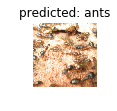

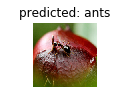

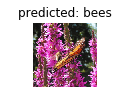

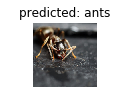

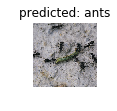

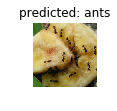

In [12]:
visualize_model(model_ft)

In [13]:
# ConvNet as fixed feature extractor

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------


train Loss: 0.1444 Acc: 0.7172


val Loss: 0.1288 Acc: 0.7386

Epoch 1/24
----------


train Loss: 0.1319 Acc: 0.7213


val Loss: 0.0533 Acc: 0.9216

Epoch 2/24
----------


train Loss: 0.1352 Acc: 0.7705


val Loss: 0.0615 Acc: 0.9216

Epoch 3/24
----------


train Loss: 0.0980 Acc: 0.8320


val Loss: 0.0438 Acc: 0.9477

Epoch 4/24
----------


train Loss: 0.0720 Acc: 0.8730


val Loss: 0.0883 Acc: 0.8627

Epoch 5/24
----------


train Loss: 0.1082 Acc: 0.8279


val Loss: 0.0452 Acc: 0.9542

Epoch 6/24
----------


train Loss: 0.0884 Acc: 0.8525


val Loss: 0.0457 Acc: 0.9477

Epoch 7/24
----------


train Loss: 0.0818 Acc: 0.8484


val Loss: 0.0566 Acc: 0.9281

Epoch 8/24
----------


train Loss: 0.0787 Acc: 0.8730


val Loss: 0.0590 Acc: 0.9281

Epoch 9/24
----------


train Loss: 0.0748 Acc: 0.8852


val Loss: 0.0522 Acc: 0.9281

Epoch 10/24
----------


train Loss: 0.0886 Acc: 0.8238


val Loss: 0.0466 Acc: 0.9477

Epoch 11/24
----------


train Loss: 0.0887 Acc: 0.8525


val Loss: 0.0612 Acc: 0.9085

Epoch 12/24
----------


train Loss: 0.0767 Acc: 0.8648


val Loss: 0.0515 Acc: 0.9477

Epoch 13/24
----------


train Loss: 0.0799 Acc: 0.8484


val Loss: 0.0473 Acc: 0.9477

Epoch 14/24
----------


train Loss: 0.0743 Acc: 0.8648


val Loss: 0.0474 Acc: 0.9346

Epoch 15/24
----------


train Loss: 0.0924 Acc: 0.8320


val Loss: 0.0537 Acc: 0.9281

Epoch 16/24
----------


train Loss: 0.0789 Acc: 0.8525


val Loss: 0.0503 Acc: 0.9412

Epoch 17/24
----------


train Loss: 0.0894 Acc: 0.8607


val Loss: 0.0621 Acc: 0.9216

Epoch 18/24
----------


train Loss: 0.0735 Acc: 0.8484


val Loss: 0.0494 Acc: 0.9412

Epoch 19/24
----------


train Loss: 0.0822 Acc: 0.8648


val Loss: 0.0466 Acc: 0.9477

Epoch 20/24
----------


train Loss: 0.0830 Acc: 0.8689


val Loss: 0.0557 Acc: 0.9412

Epoch 21/24
----------


train Loss: 0.0726 Acc: 0.8689


val Loss: 0.0498 Acc: 0.9477

Epoch 22/24
----------


train Loss: 0.0948 Acc: 0.8443


val Loss: 0.0544 Acc: 0.9346

Epoch 23/24
----------


train Loss: 0.0749 Acc: 0.8689


val Loss: 0.0488 Acc: 0.9477

Epoch 24/24
----------


train Loss: 0.0832 Acc: 0.8566


val Loss: 0.0494 Acc: 0.9477

Training complete in 28m 32s
Best val Acc: 0.954248


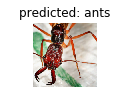

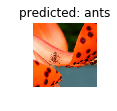

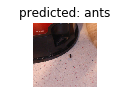

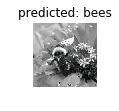

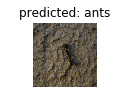

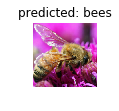

In [14]:
#Train and evaluate

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)

plt.ioff()
plt.show()